# STUDY OF FORECASTING OF VOLATILITY
Volatility is a measurement of how varied the returns of a given security or market index are over time. It is often measured from either the standard deviation or variance between those returns. In most cases, the higher the volatility, the riskier the security. Returns are preferred over price index as returns are a relatively more stable variable than index.

This study mainly focuses on these three objectives –
1. Finding the best algorithm to model the volatility of a stock.
2. Finding the best feature to model the volatility.
3. Using the best algorithm and feature to classify a set of stocks in four categories – low volatile, moderately volatile, highly volatile and extremely high volatile.

Hence this notebook is divided in three sections –
1. **SECTION 1:** Experiments with GARCH, ML, BPNN and LSTM algorithms on volatility for daily returns.
2. **SECTION 2:** Experiment whether daily, weekly or monthly returns give the best estimation for volatility.
3. **SECTION 3:** Taking the best algo and the best feature to classify 25 stocks into four categories of volatility  – low, moderate, high, extremely high.

The standard process remains the same. The data is downloaded from yfinance library. The data from Mar 2018 to Mar 2025 is used to train the model while the predictions are made for April 2025. The models are evaluated on metrics – Mean Absolute Error (MAE), Root Mean Square Error (RMSE) and R2 Score. The same set of stocks that have been used so far in study were used in categorization.

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae, root_mean_squared_error as rmse, r2_score as r2
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
!pip install xlsxwriter
%matplotlib inline

### loading data

In [5]:
# downloading data
df = yf.download('RELIANCE.NS', start='2018-03-01', end='2025-04-30')

# cleaning data
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(level=1)
df.columns.name = None
df.index.name = "Date"

# generating log return and volatility
df['log return'] = np.log(df['Close'] / df['Close'].shift(1))
df['realized Volatility'] = df['log return'].rolling(window=5).std()
df.dropna(inplace=True)
# log transform volume
df['Volume (log)'] = np.log(df['Volume'])


train = df.loc[:'2025-03-31'].copy()
test = df.loc['2025-04-01':].copy()
df.head()

/tmp/ipython-input-1649851195.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('RELIANCE.NS', start='2018-03-01', end='2025-04-30')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Close,High,Low,Open,Volume,log return,realized Volatility,Volume (log)
Date,,,,,,,,
2018-03-09,403.344574,406.105402,402.439022,404.139697,10638527,0.001809,0.020783,16.179993
2018-03-12,410.942383,412.179253,405.310325,406.392565,8315150,0.018662,0.020501,15.933590
2018-03-13,411.627075,413.460266,406.988914,411.649161,11148731,0.001665,0.018577,16.226836
2018-03-14,410.390228,411.715413,406.039184,410.279799,14724464,-0.003009,0.011941,16.505021
2018-03-15,402.770386,410.566953,401.975292,408.601247,12711836,-0.018742,0.013366,16.358044


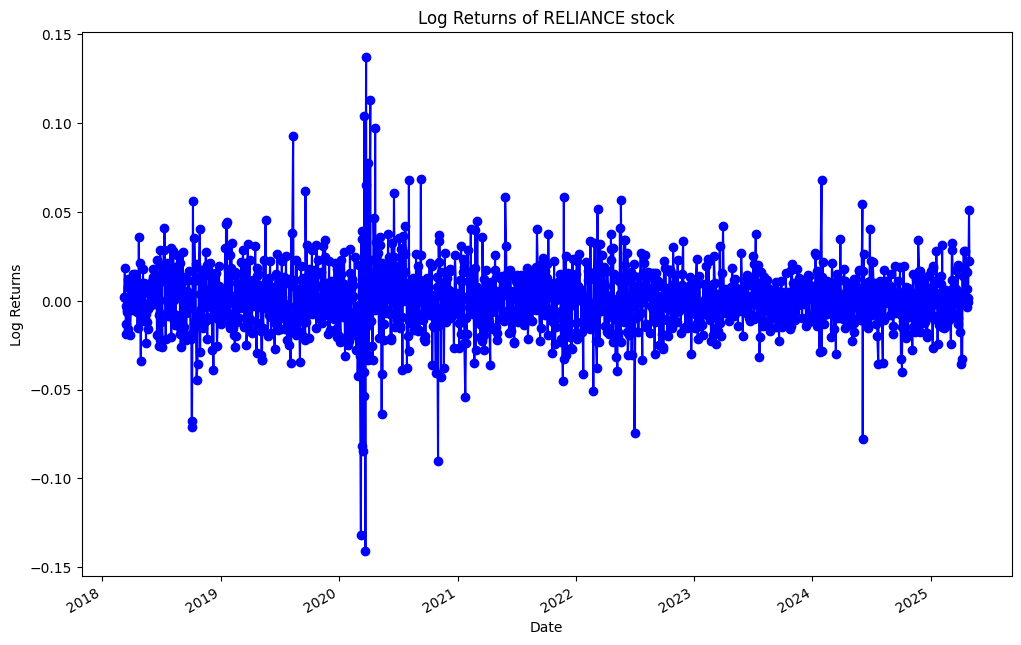

In [6]:
df['log return'].plot(figsize=(12,8), kind='line', color='blue', marker='o', linestyle='-')
plt.title("Log Returns of RELIANCE stock")
plt.ylabel("Log Returns")
plt.savefig("RELIANCE_log_return.png")
plt.show()

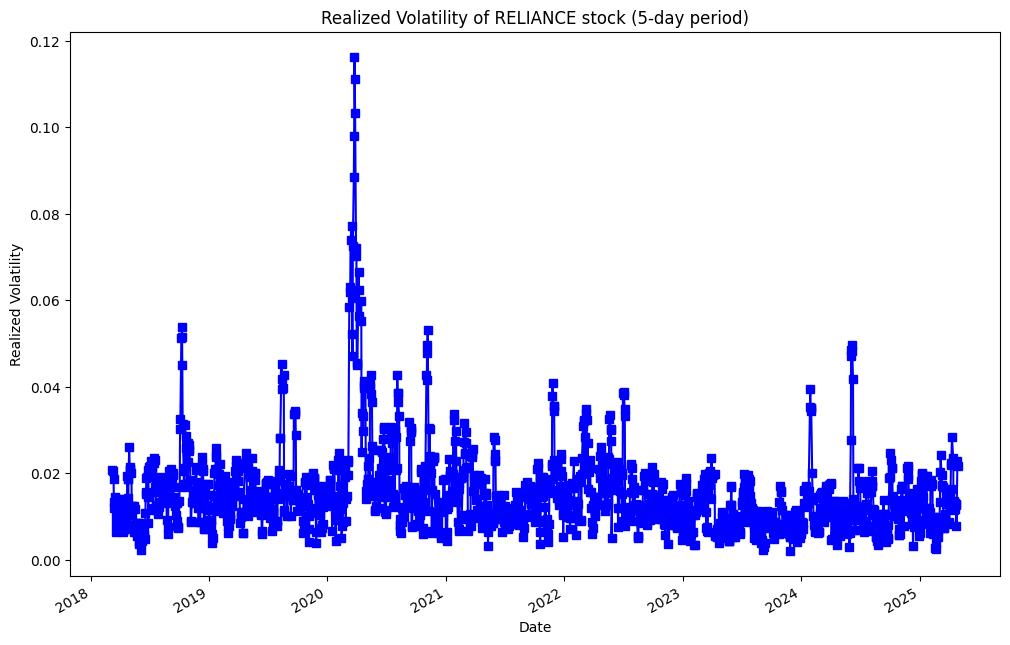

In [7]:
df['realized Volatility'].plot(figsize=(12,8), kind='line', color='blue', marker='s', linestyle='-')
plt.title("Realized Volatility of RELIANCE stock (5-day period)")
plt.ylabel("Realized Volatility")
plt.savefig("RELIANCE_log_volatility.png")
plt.show()

## SECTION 1

### GARCH

In [8]:
!pip install arch
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 13.1 MB/s eta 0:00:00


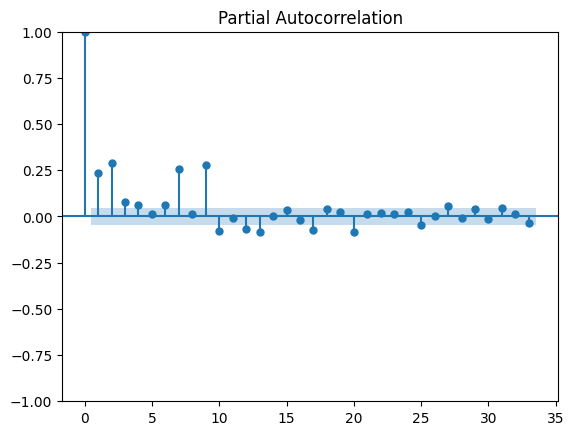

In [9]:
# finding right GARCH
plot_pacf(df['log return']**2)
plt.show()


Based on the Partial Autocorrelation plot given above the right coefficients for GARCH is (1,1)

In [10]:
# building GARCH (1,1) model
train_ret = train['log return'].dropna()*100
model = arch_model(
    train_ret,
    mean='Zero',
    vol='GARCH',
    p=1,
    q=1,
    dist='normal'
)
res = model.fit(disp='off')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:             log return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3322.20
Distribution:                  Normal   AIC:                           6650.41
Method:            Maximum Likelihood   BIC:                           6666.80
                                        No. Observations:                 1743
Date:                Fri, Jan 02 2026   Df Residuals:                     1743
Time:                        04:29:03   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1602  7.387e-02      2.168  3.015e-02 [1.538e-02,  0.305]
alpha[1]       0.1043  3.681e-02      2.833  4.609e-03 [3.214e-02,  0.176]
beta[1]        0.8447  5.105e-02     16.547  1.669e-61   [  0.745,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [11]:
# sanity check
# sum of alpha and beta should be less than 1
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']
print('alpha + beta = ', alpha+beta)

# p-value
std_resid = res.std_resid
acorr_ljungbox(std_resid, lags=10, return_df=True)
acorr_ljungbox(std_resid**2, lags=10, return_df=True)

alpha + beta =  0.9489709009611893


,lb_stat,lb_pvalue
1,0.773381,0.379173
2,0.774306,0.678987
3,0.914757,0.821865
4,1.216540,0.875368
5,1.473086,0.916155
6,1.607445,0.952041
7,1.639422,0.977087
8,1.853664,0.985174
9,3.051928,0.962201
10,3.069250,0.979747


The sum of alpha+beta is very close to, although less than 1. This means that the shocks to volatility last long but the volatility is stable.
Every single p-value for the std_resid is greater than 0.05 which means that the residuals come mostly from white noise and are not correlated.

In [12]:
# making forecast for April
returns = df['log return'].dropna()*100
train_ret = returns.loc[train.index]
test_ret  = returns.loc[test.index]
train_len = len(train_ret)
test_len = len(test)

garch_pred = []
for i in range(test_len):
  train_i = returns.iloc[:train_len+i]
  model = arch_model(
      train_i,
      mean='Zero',
      vol='GARCH',
      p=1,
      q=1
  )
  res_i = model.fit(disp='off')
  f = res_i.forecast(horizon=1)
  garch_pred.append(f.variance.iloc[-1, 0])

test['pred_vol_garch'] = np.sqrt(garch_pred)/100
test.head()

,Close,High,Low,Open,Volume,log return,realized Volatility,Volume (log),pred_vol_garch
Date,,,,,,,,,
2025-04-01,1247.617065,1272.816469,1244.330266,1259.569329,12099648,-0.017803,0.008636,16.308687,0.013648
2025-04-02,1246.172974,1250.555495,1238.951814,1242.587319,10142590,-0.001158,0.008488,16.132254,0.014371
2025-04-03,1243.732666,1246.820432,1228.145018,1228.145018,7434366,-0.001960,0.008212,15.821624,0.013802
2025-04-04,1199.907593,1240.495487,1188.403612,1236.162816,17908652,-0.035873,0.015111,16.700795,0.013310
2025-04-07,1161.062744,1166.590715,1110.415052,1127.696009,22156106,-0.032909,0.016452,16.913624,0.017311


In [13]:
# metrics
mae_garch = mae(test['realized Volatility'], test['pred_vol_garch'])
rmse_garch = rmse(test['realized Volatility'], test['pred_vol_garch'])
r2_garch = r2(test['realized Volatility'], test['pred_vol_garch'])
print(f'MAE: {mae_garch}')
print(f'RMSE: {rmse_garch}')
print(f'R2: {r2_garch}')

MAE: 0.0049802651696496175
RMSE: 0.0056188864777576035
R2: 0.15445208814518685


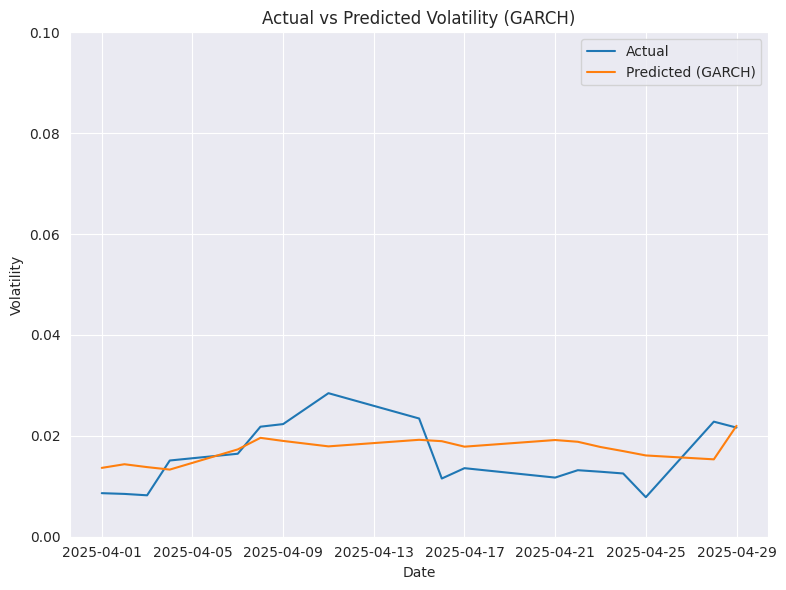

In [14]:
# plotting
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(data=test, x='Date', y='realized Volatility', label='Actual')
sns.lineplot(data=test, x='Date', y='pred_vol_garch', label='Predicted (GARCH)')
plt.title('Actual vs Predicted Volatility (GARCH)')
plt.ylim(0, 0.1)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("GARCH_actual_vs_predicted.png")
plt.show()

### ML

#### feature extraction

In [15]:
for l in [1, 2, 5, 10]:
    df[f'vol_lag_{l}'] = df['realized Volatility'].shift(l)

df['volume_lag1'] = np.log(df['Volume']).shift(1)

df['sq_ret_lag1'] = (df['log return'] ** 2).shift(1)

df['parkinson_5'] = (
    (np.log(df['High'] / df['Low']) ** 2)
    .rolling(5)
    .mean()
    .shift(1)
)

df['parkinson_10'] = (
    (np.log(df['High'] / df['Low']) ** 2)
    .rolling(10)
    .mean()
    .shift(1)
)

log_hl = np.log(df['High'] / df['Low'])
log_co = np.log(df['Close'] / df['Open'])
gk_term = 0.5 * log_hl**2 - (2*np.log(2) - 1) * log_co**2

df['gk_5'] = gk_term.rolling(5).mean().shift(1)
df['gk_10'] = gk_term.rolling(10).mean().shift(1)

df.dropna(inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

feat = [
    'sq_ret_lag1',
    'parkinson_5', 'parkinson_10',
    'gk_5', 'gk_10',
    'volume_lag1',
    'vol_lag_1', 'vol_lag_2', 'vol_lag_5', 'vol_lag_10'
]

split_date = '2025-04-01'

train = df.loc[df.index < split_date].copy()
test1 = df.loc[df.index >= split_date].copy()

X_train = train[feat]
y_train = train['realized Volatility']

X_test = test1[feat]
y_test = test1['realized Volatility']

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
test['pred_vol_lr'] = y_pred_lr

# metrics
mae_lr = mae(y_test, y_pred_lr)
rmse_lr = rmse(y_test, y_pred_lr)
r2_lr = r2(y_test, y_pred_lr)

print(f'MAE: {mae_lr}')
print(f'RMSE: {rmse_lr}')
print(f'R2: {r2_lr}')

MAE: 0.0034992803441039363
RMSE: 0.004953003089883759
R2: 0.3429855768891492


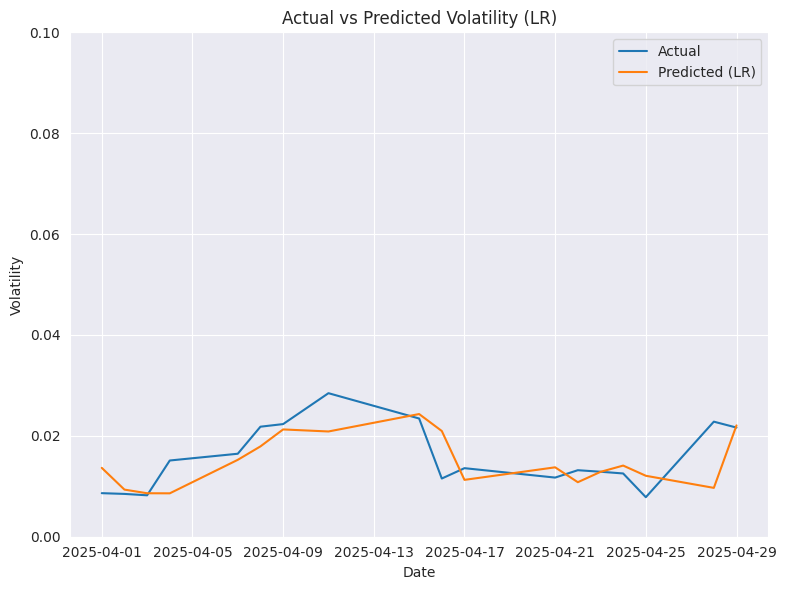

In [17]:
# plotting
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(data=test, x='Date', y='realized Volatility', label='Actual')
sns.lineplot(data=test, x='Date', y='pred_vol_lr', label='Predicted (LR)')
plt.title('Actual vs Predicted Volatility (LR)')
plt.ylim(0, 0.1)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("LR_actual_vs_predicted.png")
plt.show()

#### SVR

In [18]:
from sklearn.svm import SVR

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf"))
])

param_grid_svr = {
    "svr__C": [0.1, 1, 10, 50, 100, 500],
    "svr__epsilon": [0.01, 0.05, 0.1, 0.2],
    "svr__gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}


tscv = TimeSeriesSplit(n_splits=5)

gscv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_svr,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gscv.fit(X_train, y_train)

best_model_svr = gscv.best_estimator_

y_pred_svr = best_model_svr.predict(X_test)
test['pred_vol_svr'] = y_pred_svr

mae_svr = mae(y_test, y_pred_svr)
rmse_svr = rmse(y_test, y_pred_svr)
r2_svr = r2(y_test, y_pred_svr)

print(f"MAE: {mae_svr}")
print(f"RMSE: {rmse_svr}")
print(f'R2: {r2_svr}')


Fitting 5 folds for each of 120 candidates, totalling 600 fits
MAE: 0.0035208527755864203
RMSE: 0.004816933243388712
R2: 0.37858896545999043


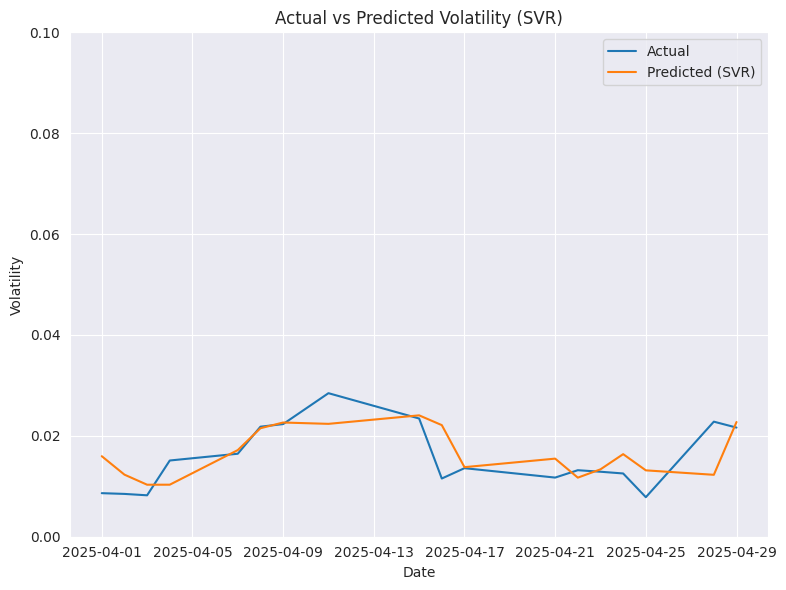

In [19]:
# plotting
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(data=test, x='Date', y='realized Volatility', label='Actual')
sns.lineplot(data=test, x='Date', y='pred_vol_svr', label='Predicted (SVR)')
plt.title('Actual vs Predicted Volatility (SVR)')
plt.ylim(0, 0.1)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("SVR_actual_vs_predicted.png")
plt.show()

#### Random Forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [300, 600, 1000],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", 0.5, 0.8]
}


tscv = TimeSeriesSplit(n_splits=5)

gscv = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gscv.fit(X_train, y_train)

best_model = gscv.best_estimator_

y_pred_rf = best_model.predict(X_test)
test['pred_vol_rf'] = y_pred_rf

mae_rf = mae(y_test, y_pred_rf)
rmse_rf = rmse(y_test, y_pred_rf)
r2_rf = r2(y_test, y_pred_rf)

print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")
print(f'R2: {r2_rf}')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
MAE: 0.003896405998755704
RMSE: 0.005569370016392184
R2: 0.16928921195179636


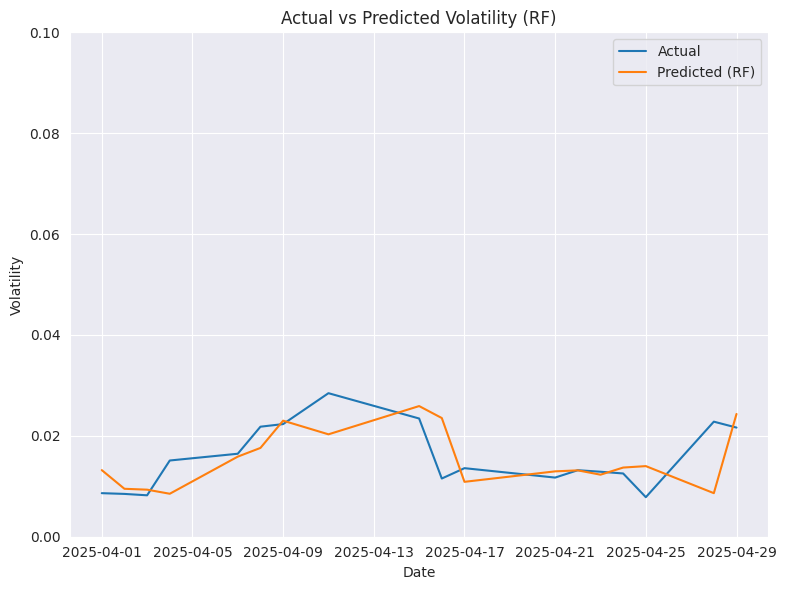

In [21]:
# plotting
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(data=test, x='Date', y='realized Volatility', label='Actual')
sns.lineplot(data=test, x='Date', y='pred_vol_rf', label='Predicted (RF)')
plt.title('Actual vs Predicted Volatility (RF)')
plt.ylim(0, 0.1)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("RF_actual_vs_predicted.png")
plt.show()

#### XGB Regressor

In [22]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

param_grid_xgb = {
    "n_estimators": [400, 800, 1200],
    "max_depth": [2, 3, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}


tscv = TimeSeriesSplit(n_splits=5)

gscv = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gscv.fit(X_train, y_train)

best_model = gscv.best_estimator_

y_pred_xgbr = best_model.predict(X_test)
test['pred_vol_xgbr'] = y_pred_xgbr

mae_xgbr = mae(y_test, y_pred_xgbr)
rmse_xgbr = rmse(y_test, y_pred_xgbr)
r2_xgbr = r2(y_test, y_pred_xgbr)

print("MAE:", mae_xgbr)
print("RMSE:", rmse_xgbr)
print('R2:', r2_xgbr)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
MAE: 0.0036916981576179475
RMSE: 0.005308919523873657
R2: 0.2451685446053371


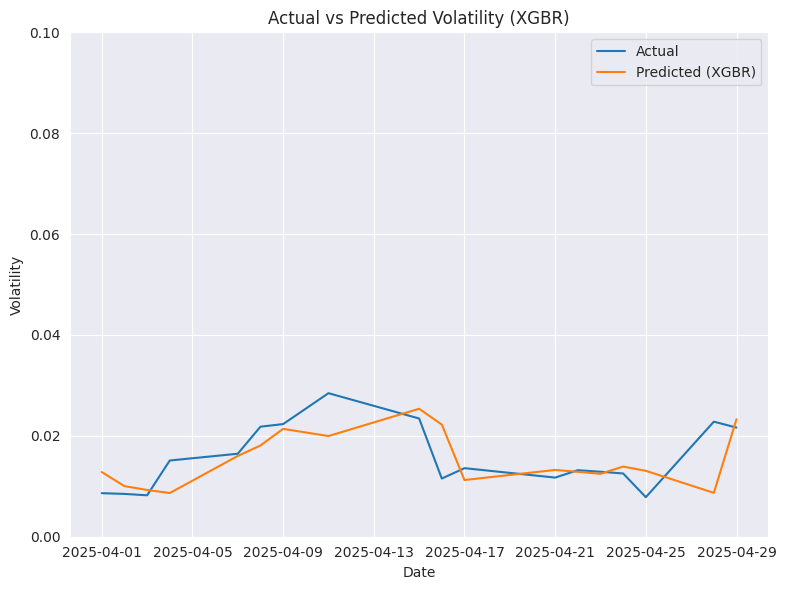

In [23]:
# plotting
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(data=test, x='Date', y='realized Volatility', label='Actual')
sns.lineplot(data=test, x='Date', y='pred_vol_xgbr', label='Predicted (XGBR)')
plt.title('Actual vs Predicted Volatility (XGBR)')
plt.ylim(0, 0.1)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("XGBR_actual_vs_predicted.png")
plt.show()

### BPNN

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to numpy arrays for scaling
X_train_np = X_train.values
y_train_np = y_train.values.reshape(-1, 1) # Ensure y is 2D for StandardScaler
X_test_np = X_test.values
y_test_np = y_test.values.reshape(-1, 1)

sx = StandardScaler()
sy = StandardScaler()

# Scale the numpy arrays
Xtr_scaled_np = sx.fit_transform(X_train_np)
ytr_scaled_np = sy.fit_transform(y_train_np)
Xte_scaled_np = sx.transform(X_test_np)
yte_scaled_np = sy.transform(y_test_np)

# Convert scaled numpy arrays to torch tensors
Xtr = torch.tensor(Xtr_scaled_np, dtype=torch.float32).to(device)
ytr = torch.tensor(ytr_scaled_np, dtype=torch.float32).to(device)
Xte = torch.tensor(Xte_scaled_np, dtype=torch.float32).to(device)
yte = torch.tensor(yte_scaled_np, dtype=torch.float32).to(device)

train_ds = TensorDataset(Xtr, ytr)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=False)

class BPNN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = BPNN(Xtr.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 200
for _ in range(epochs):
    model.train()
    for xb, yb in train_dl:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy().ravel()


y_pred_bpnn = sy.inverse_transform(y_pred.reshape(-1, 1))
test.loc[:, 'pred_vol_bpnn'] = y_pred_bpnn.flatten()

mae_bpnn = mae(y_test_np, y_pred_bpnn)
rmse_bpnn = rmse(y_test_np, y_pred_bpnn)
r2_bpnn = r2(y_test_np, y_pred_bpnn)

print(f'MAE: {mae_bpnn}')
print(f'RMSE: {rmse_bpnn}')
print(f'R2: {r2_bpnn}')

MAE: 0.004090651784424215
RMSE: 0.005658151886441455
R2: 0.14259322968479338


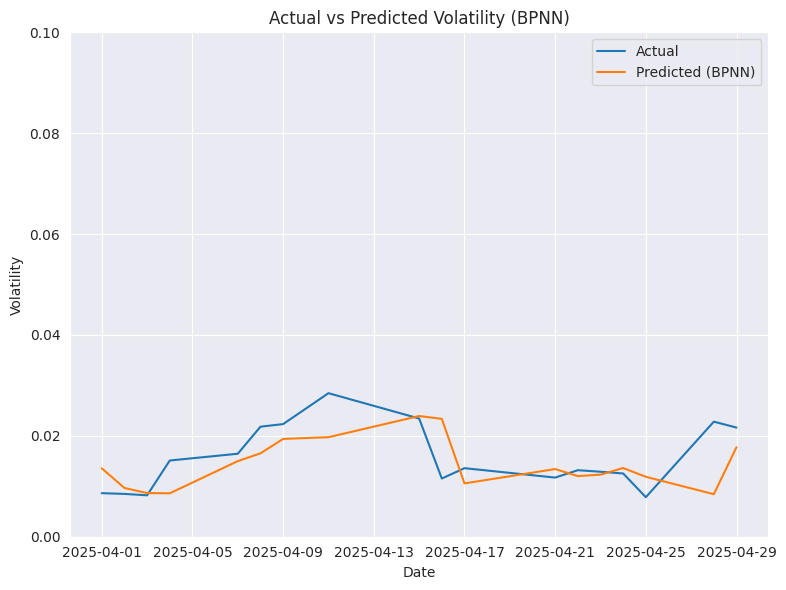

In [25]:
# plotting
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(data=test, x='Date', y='realized Volatility', label='Actual')
sns.lineplot(data=test, x='Date', y='pred_vol_bpnn', label='Predicted (BPNN)')
plt.title('Actual vs Predicted Volatility (BPNN)')
plt.ylim(0, 0.1)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("BPNN_actual_vs_predicted.png")
plt.show()

### LSTM

In [26]:
def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

lookback = 5

Xtr_seq, ytr_seq = make_sequences(Xtr_scaled_np, ytr_scaled_np, lookback)
Xte_seq, yte_seq = make_sequences(Xte_scaled_np, yte_scaled_np, lookback)


In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

n_features = Xtr_seq.shape[2]

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, n_features)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

model.fit(
    Xtr_seq,
    ytr_seq,
    epochs=200,
    batch_size=64,
    shuffle=False,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.9870 - val_loss: 0.2409
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6843 - val_loss: 0.2116
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5422 - val_loss: 0.1940
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4425 - val_loss: 0.1847
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3744 - val_loss: 0.1873
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3923 - val_loss: 0.1636
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3879 - val_loss: 0.1701
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3783 - val_loss: 0.1639
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3184 - val_loss: 0.1625
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3126 - val_loss: 0.1624
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3071 - val_loss: 0.1606
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3

In [28]:
y_pred_lstm_scaled = model.predict(Xte_seq)
y_pred_lstm = sy.inverse_transform(y_pred_lstm_scaled).flatten()
# y_true = sy.inverse_transform(yte_seq) # This is the scaled true values for the sequences

# Create a Series for LSTM predictions with the correct index
pred_vol_lstm_series = pd.Series(y_pred_lstm, index=y_test.index[lookback:])

# Now, we need to extract the actual and predicted values for metric calculation
y_true_for_metrics = y_test.loc[y_test.index[lookback:]]
y_pred_for_metrics = pred_vol_lstm_series

# Calculate metrics
mae_lstm = mae(y_true_for_metrics, y_pred_for_metrics)
rmse_lstm = rmse(y_true_for_metrics, y_pred_for_metrics)
r2_lstm = r2(y_true_for_metrics, y_pred_for_metrics)

print(f'MAE: {mae_lstm}')
print(f'RMSE: {rmse_lstm}')
print(f'R2: {r2_lstm}')

# To ensure the global 'test' variable is updated for subsequent plotting cells,
# we add the 'pred_vol_lstm' to the existing 'test' DataFrame using `update`.
# First, ensure 'pred_vol_lstm' column exists in 'test', initialized with NaNs where no prediction exists.
if 'pred_vol_lstm' not in test.columns:
    test['pred_vol_lstm'] = np.nan
# Update 'test' with the newly created pred_vol_lstm_series.
# `update` will align by index and only update existing rows in 'test'.
test.update(pred_vol_lstm_series)

# The original line `test.dropna(inplace=True)` should be kept if the intention is to only plot
# complete rows that have all predictions from all models.
test.dropna(inplace=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
MAE: 0.0048993431484784505
RMSE: 0.005788853274072498
R2: 0.09910743746449857


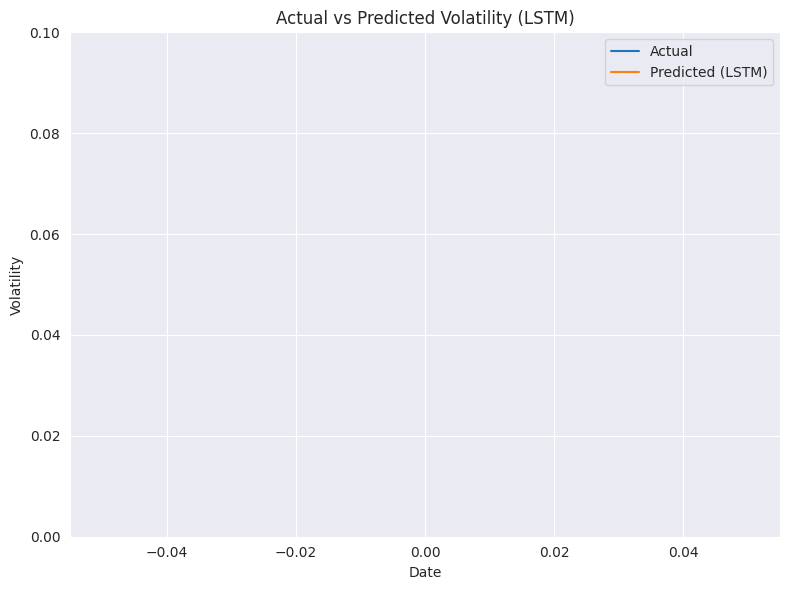

In [29]:
# plotting
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.lineplot(data=test, x='Date', y='realized Volatility', label='Actual')
sns.lineplot(data=test, x='Date', y='pred_vol_lstm', label='Predicted (LSTM)')
plt.title('Actual vs Predicted Volatility (LSTM)')
plt.ylim(0, 0.1)
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("LSTM_actual_vs_predicted.png")
plt.show()


### Summary

In [30]:
results = {
    "Model": [
        "GARCH(1,1)",
        "Linear Regression",
        "SVR (RBF)",
        "Random Forest",
        "XGBoost",
        "BPNN",
        "LSTM"
    ],
    "MAE": [
        mae_garch,
        mae_lr,
        mae_svr,
        mae_rf,
        mae_xgbr,
        mae_bpnn,
        mae_lstm
    ],
    "RMSE": [
        rmse_garch,
        rmse_lr,
        rmse_svr,
        rmse_rf,
        rmse_xgbr,
        rmse_bpnn,
        rmse_lstm
    ],
    "R2": [
        r2_garch,
        r2_lr,
        r2_svr,
        r2_rf,
        r2_xgbr,
        r2_bpnn,
        r2_lstm
    ]
}

summary_df = pd.DataFrame(results).set_index("Model")
summary_df.to_excel('summary.xlsx', engine='xlsxwriter')
summary_df.sort_values("RMSE")



,MAE,RMSE,R2
Model,,,
SVR (RBF),0.003521,0.004817,0.378589
Linear Regression,0.003499,0.004953,0.342986
XGBoost,0.003692,0.005309,0.245169
Random Forest,0.003896,0.005569,0.169289
"GARCH(1,1)",0.004980,0.005619,0.154452
BPNN,0.004091,0.005658,0.142593
LSTM,0.004899,0.005789,0.099107


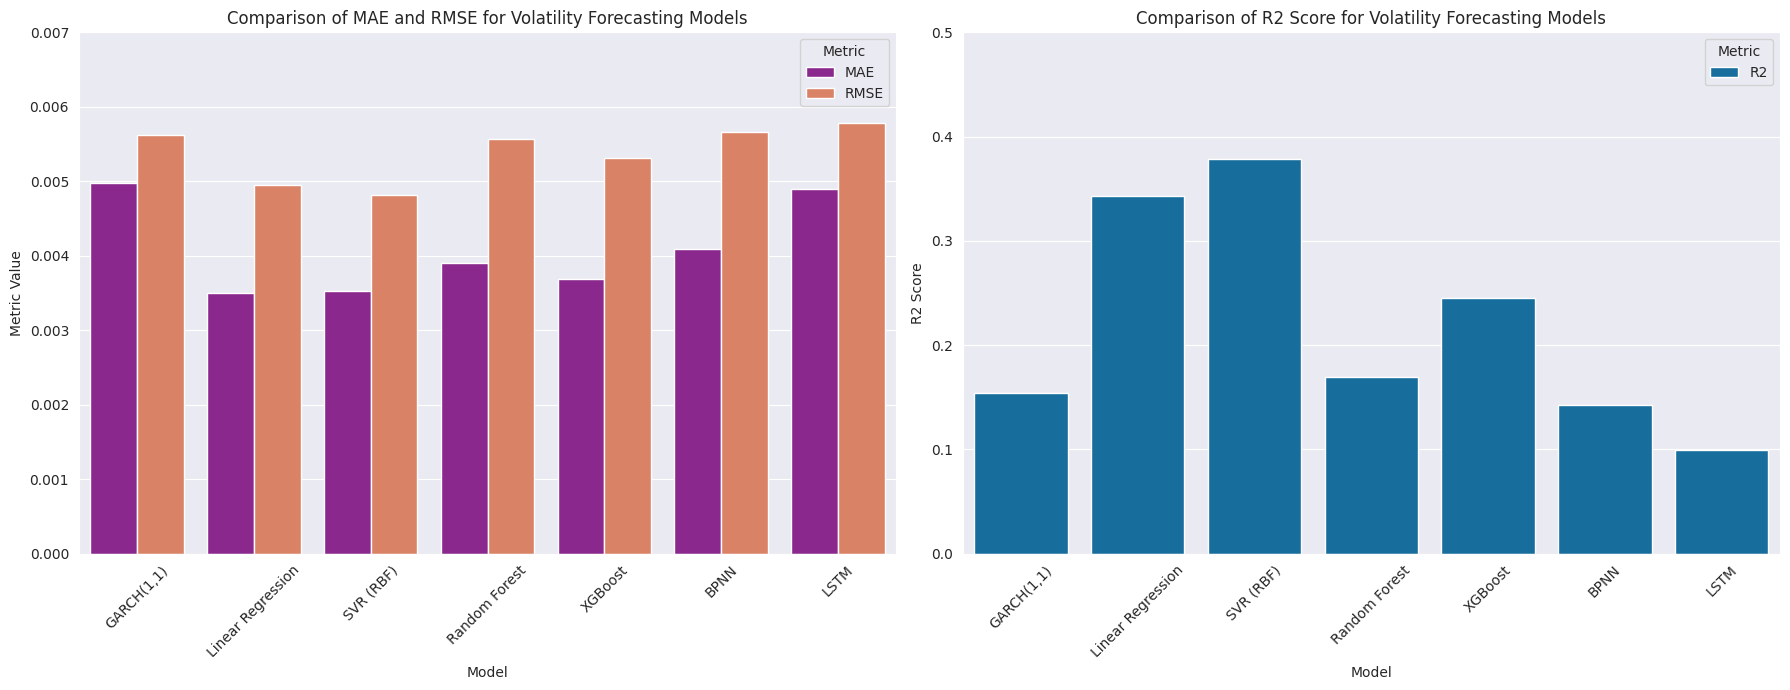

In [31]:
# Melt the DataFrame to long format for plotting
summary_df_melted = summary_df.reset_index().melt(
    id_vars=['Model'],
    value_vars=['MAE', 'RMSE', 'R2'],
    var_name='Metric',
    value_name='Value'
)

# Create two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # 1 row, 2 columns
sns.set_style('darkgrid')

# Plot MAE and RMSE on the first subplot
sns.barplot(
    data=summary_df_melted[summary_df_melted['Metric'].isin(['MAE', 'RMSE'])],
    x='Model',
    y='Value',
    hue='Metric',
    palette='plasma',
    ax=axes[0] # Specify the subplot
)
axes[0].set_title('Comparison of MAE and RMSE for Volatility Forecasting Models')
axes[0].set_ylabel('Metric Value')
axes[0].set_xlabel('Model')
axes[0].set_ylim(0, 0.007) # Set y-axis limit appropriate for MAE and RMSE
axes[0].tick_params(axis='x', rotation=45) # Rotate x-axis labels
axes[0].legend(title='Metric')

# Plot R2 on the second subplot
sns.barplot(
    data=summary_df_melted[summary_df_melted['Metric'] == 'R2'],
    x='Model',
    y='Value',
    hue='Metric',
    palette='colorblind',
    ax=axes[1] # Specify the subplot
)
axes[1].set_title('Comparison of R2 Score for Volatility Forecasting Models')
axes[1].set_ylabel('R2 Score')
axes[1].set_xlabel('Model')
axes[1].set_ylim(0, 0.5) # Set y-axis limit appropriate for R2
axes[1].tick_params(axis='x', rotation=45) # Rotate x-axis labels
axes[1].legend(title='Metric')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.savefig('model_metrics_comparison_split.png')
plt.show()

## SECTION 2

In [39]:
def compute_returns(df, freq):
    px = df['Close'].resample(freq).last()
    ret = np.log(px / px.shift(1))
    return ret.dropna()
def realized_volatility(ret, window):
    return ret.rolling(window).std().dropna()
freq_config = {
    "Daily":   {"freq": "D", "window": 5},
    "Weekly":  {"freq": "W", "window": 4},
    "Monthly": {"freq": "ME", "window": 3} # Changed 'M' to 'ME'
}

In [40]:
def build_features(ret, rv):
  df_feat = pd.DataFrame({
      'rv':rv,
      'rv_lag1':rv.shift(1),
      'rv_lag2':rv.shift(2),
      'sq_ret_lag1': (ret**2).shift(1)
  })
  return df_feat.dropna()

In [41]:
section2_results = []
for label, cfg in freq_config.items():
  ret = compute_returns(df, cfg['freq'])
  rv = realized_volatility(ret, cfg['window'])
  data = build_features(ret, rv)

  train = data.loc[:'2025-03-31']
  test = data.loc['2025-04-01':]

  X_train = train.drop(columns='rv')
  y_train = train['rv']

  X_test = test.drop(columns='rv')
  y_test = test['rv']

  sx = StandardScaler()
  sy = StandardScaler()

  Xtr = sx.fit_transform(X_train)
  ytr = sy.fit_transform(y_train.values.reshape(-1, 1)).ravel()
  Xte = sx.transform(X_test)
  yte = sy.transform(y_test.values.reshape(-1, 1)).ravel()

  best_model_svr.fit(Xtr, ytr)

  # Fixed: Removed .ravel() after reshaping to ensure 2D array input to inverse_transform
  pred = sy.inverse_transform(best_model_svr.predict(Xte).reshape(-1, 1))
  section2_results.append({
      'Frequency': label,
      'MAE': mae(y_test, pred),
      'RMSE': rmse(y_test, pred),
      'R2': r2(y_test, pred)
  })

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [42]:
section2_df = pd.DataFrame(section2_results)
section2_df.set_index('Frequency', inplace=True)
section2_df.to_excel('section2_results.xlsx', engine='xlsxwriter')
section2_df.sort_values("RMSE")

,MAE,RMSE,R2
Frequency,,,
Daily,0.003598,0.004562,0.216128
Weekly,0.008485,0.008949,-1.408817
Monthly,0.015076,0.015076,NaN


This means that the best results come from SVR model based on daily returns.

## SECTION 3

In [44]:
tickers = [
    "RELIANCE.NS",     # Large-cap
    "TCS.NS",          # Large-cap
    "HDFCBANK.NS",     # Large-cap
    "PIDILITIND.NS",   # Mid-cap
    "AUBANK.NS",       # Mid-cap
    "IEX.NS",          # Small-cap
    "MAPMYINDIA.NS",   # Small-cap
    "LTTS.NS",          # Small-cap / mid-tech
    "AAPL",     # Large-cap
    "MSFT",     # Large-cap
    "GOOGL",    # Large-cap
    "AMZN",     # Large-cap
    "NVDA",     # Large-cap
    "CRWD",     # Mid-cap
    "PLTR",     # Mid-cap
    "FSLR",     # Mid-cap
    "CELH",     # Small-cap
    "U",         # Small-cap / mid-tech
    "HSBA.L",   # Large-cap
    "BP.L",     # Large-cap
    "ULVR.L",   # Large-cap
    "AUTO.L",   # Mid-cap
    "JDW.L",    # Mid-cap
    "ASC.L",    # Small-cap
]

In [45]:
from sklearn.base import clone

class SVRVolatilityBucket:
    def __init__(
        self,
        tickers,
        base_svr_model,
        vol_window=5,
        train_end="2025-03-31",
        test_start="2025-04-01"
    ):
        self.tickers = tickers
        self.base_svr_model = base_svr_model
        self.vol_window = vol_window
        self.train_end = train_end
        self.test_start = test_start

    def _prepare_features(self, df):
        df["log_ret"] = np.log(df["Close"] / df["Close"].shift(1))
        df["rv"] = df["log_ret"].rolling(self.vol_window).std()

        df["rv_lag1"] = df["rv"].shift(1)
        df["rv_lag2"] = df["rv"].shift(2)
        df["sq_ret_lag1"] = (df["log_ret"] ** 2).shift(1)

        df.dropna(inplace=True)

        train = df.loc[:self.train_end]
        test  = df.loc[self.test_start:]

        X_train = train[["rv_lag1", "rv_lag2", "sq_ret_lag1"]]
        y_train = train["rv"]

        X_test = test[["rv_lag1", "rv_lag2", "sq_ret_lag1"]]

        return X_train, y_train, X_test

    def _predict_mean_vol(self, ticker):
        df = yf.download(ticker, start="2018-03-01", end="2025-04-30")
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)

        X_train, y_train, X_test = self._prepare_features(df)

        sx = StandardScaler()
        sy = StandardScaler()

        Xtr = sx.fit_transform(X_train)
        ytr = sy.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        Xte = sx.transform(X_test)

        model = clone(self.base_svr_model)
        model.fit(Xtr, ytr)

        y_pred = sy.inverse_transform(
            model.predict(Xte).reshape(-1, 1)
        ).ravel()

        return y_pred.mean()

    def classify(self):
        vol_scores = {}

        for t in self.tickers:
            vol_scores[t] = self._predict_mean_vol(t)

        vol_series = pd.Series(vol_scores)

        q1, q2, q3 = vol_series.quantile([0.25, 0.5, 0.75])

        buckets = {
            "Low": vol_series[vol_series <= q1].index.tolist(),
            "Moderate": vol_series[(vol_series > q1) & (vol_series <= q2)].index.tolist(),
            "High": vol_series[(vol_series > q2) & (vol_series <= q3)].index.tolist(),
            "Extremely High": vol_series[vol_series > q3].index.tolist()
        }

        return pd.DataFrame(
            {k: pd.Series(v) for k, v in buckets.items()}
        )


In [47]:
bucket = SVRVolatilityBucket(
    tickers=tickers,
    base_svr_model=best_model_svr
)

volatility_table = bucket.classify()
volatility_table.to_excel('volatility_table.xlsx', engine='xlsxwriter')
volatility_table


/tmp/ipython-input-3856242945.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-03-01", end="2025-04-30")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3856242945.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-03-01", end="2025-04-30")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3856242945.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-03-01", end="2025-04-30")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3856242945.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2018-03-01", end="2025-04-30")
[*********************100%***********************]  1 of 1 completed
/tmp

,Low,Moderate,High,Extremely High
0,RELIANCE.NS,MAPMYINDIA.NS,AUBANK.NS,AAPL
1,TCS.NS,LTTS.NS,MSFT,NVDA
2,HDFCBANK.NS,HSBA.L,GOOGL,CRWD
3,PIDILITIND.NS,BP.L,AMZN,PLTR
4,IEX.NS,AUTO.L,CELH,FSLR
5,ULVR.L,JDW.L,ASC.L,U
